In [1]:
import tensorflow as tf
from os import path, getcwd, chdir
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D
import numpy as np

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "D:\Conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-b353d4241a5d>", line 1, in <module>
    import tensorflow as tf
  File "D:\Conda\envs\tf\lib\site-packages\tensorflow\__init__.py", line 41, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "D:\Conda\envs\tf\lib\site-packages\tensorflow\python\__init__.py", line 47, in <module>
    from tensorflow.python import keras
  File "D:\Conda\envs\tf\lib\site-packages\tensorflow\python\keras\__init__.py", line 27, in <module>
    from tensorflow.python.keras import models
  File "D:\Conda\envs\tf\lib\site-packages\tensorflow\python\keras\models.py", line 27, in <module>
    from tensorflow.python.keras.engine import sequential
  File "D:\Cond

TypeError: object of type 'NoneType' has no len()

In [2]:
mnist_fashion = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist_fashion.load_data()

In [3]:
training_images.shape, training_labels.shape

((60000, 28, 28), (60000,))

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

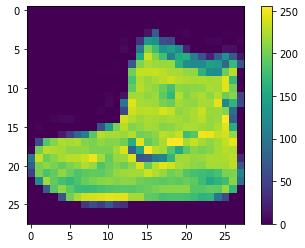

In [5]:
plt.figure()
plt.imshow(training_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

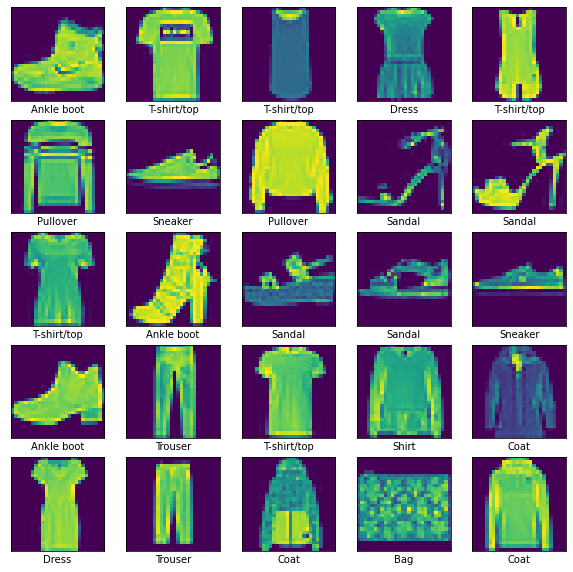

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i])
    plt.xlabel(class_names[training_labels[i]])
plt.show()

Define the Model

In [7]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation = 'relu')
        self.flatten = Flatten()
        self.d1 = Dense(128,  activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

Define the loss and accurancy for the Train and Test

In [8]:
def get_LossAndOptimizer():
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    optimizer = tf.keras.optimizers.Adam()
    return loss_object, optimizer
    
def get_TrainLossAcc():
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accurancy = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_accuracy')
    return train_loss, train_accurancy

def get_TestLossAcc():
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    test_accurancy = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_accuracy')
    return test_loss, test_accurancy

Define a Train_Step Function

In [9]:
@tf.function
def train_step(images, labels, model, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    return loss        



Define the Test_Step Function 

In [10]:
@tf.function
def test_step(images, labels, model, loss_object, test_loss, test_accurancy):
    predictions = model(images, training = False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accurancy(labels, predictions)
    return t_loss

Define function to return datasets

In [11]:
def get_data(BATCH = 32):
    mnist_fashion = tf.keras.datasets.fashion_mnist
    (training_images, training_labels), (test_images, test_labels) = mnist_fashion.load_data()
    training_images, test_images = training_images / 255.0, test_images / 255.0
    # Add a channels dimension
    training_images = training_images[..., tf.newaxis].astype("float32")
    test_images = test_images[..., tf.newaxis].astype("float32")
    train_ds = tf.data.Dataset.from_tensor_slices((training_images, training_labels)).shuffle(10000).batch(BATCH)
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH)
    return train_ds, test_ds

In [12]:
def learn(model,EPOCHS = 5):
    
    train_ds, test_ds = get_data()

    loss_object, optimizer = get_LossAndOptimizer()
    train_loss, train_accuracy = get_TrainLossAcc()
    test_loss, test_accuracy = get_TestLossAcc()
    
    for epoch in range(EPOCHS):
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        #TRAIN PART
        for images, labels in train_ds:
            loss_object = train_step(images, labels, model, loss_object, optimizer, train_loss, train_accuracy)
        #TEST PART
        for images, labels in test_ds:
            loss_object = test_step(images, labels, model, loss_object, test_loss, test_accuracy)
        
        print(
            f'Epoch {epoch + 1}, '
            f'Loss: {train_loss.result()}, '
            f'Accuracy: {train_accuracy.result() * 100}, '
            f'Test Loss: {test_loss.result()}, '
            f'Test Accuracy: {test_accuracy.result() * 100}'
        )


In [13]:
model = MyModel()
learn(model)

Epoch 1, Loss: 0.3773263096809387, Accuracy: 105.43840026855469, Test Loss: 0.3068159818649292, Test Accuracy: 100.32251739501953
Epoch 2, Loss: 0.24344825744628906, Accuracy: 85.82447052001953, Test Loss: 0.2698317766189575, Test Accuracy: 84.54736328125
Epoch 3, Loss: 0.188213050365448, Accuracy: 74.04939270019531, Test Loss: 0.27621331810951233, Test Accuracy: 76.15225219726562
Epoch 4, Loss: 0.14503876864910126, Accuracy: 64.150390625, Test Loss: 0.27118223905563354, Test Accuracy: 74.55626678466797
Epoch 5, Loss: 0.10940051078796387, Accuracy: 56.48442459106445, Test Loss: 0.29742109775543213, Test Accuracy: 74.10995483398438
